# Analysis of a bias-free network

A bias-free network operates on its input by applying an adaptive linear transform (adaptive, because the transform is dependent on the input image). In this notebook, we analyze the properties of this transform using singular value decomposition.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [ ]:
# set to google drive location by default
file_root_path = '/content/drive/MyDrive/Denoising Code/Denoising_Tutorial'

# if the files are in local devices, change the file_root_path to the local location


In [1]:
from google.colab import drive
drive.mount('/content/drive')

import os
import sys

sys.path.append(file_root_path)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# !pip install ipywidgets

In [3]:
# !jupyter labextension list

In [4]:
import warnings

# This line suppresses all warnings.
warnings.filterwarnings('ignore')

In [5]:

import numpy as np
import matplotlib.pylab as plt
import matplotlib.patches as patches
import os
import torch
from skimage import io
# from skimage.measure.simple_metrics import compare_psnr, compare_mse
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from skimage.metrics import mean_squared_error  as compare_mse
import sys
from utils import *
import time

# %matplotlib widget
# %matplotlib notebook

In [6]:
# Paths for data, pretrained models, and precomputed performance measures
pretrained_base = file_root_path + '/bias_free_denoising/pretrained/'
precomputed_base = file_root_path + '/bias_free_denoising/precomputed/'
data_base = file_root_path + '/bias_free_denoising/data/'

# Datasets available in the data folder
train_folder_path = os.path.join(data_base, 'Train400/')
test_folder_path = os.path.join(data_base, 'Test/Set68/')
set12_path = os.path.join(data_base, 'Test/Set12/')
kodak_path = os.path.join(data_base, 'Test/Kodak23/')

### Choose a model

Note: we provide four pre-trained models. You can train and analyze any other model (and its bias-free counterpart) using the train script provided in the repository.

In [7]:
# Choose a model (pre-trained options: 'dncnn', 'unet', 'rcnn', 'sdensenet')
model = 'dncnn'

# Select the range of noise levels (stdev, relative to intensities in range [0,255])
# used during training (options are 0-10, 0-30, 0-55, 0-100).
l = 0   # lower bound of training range
h = 100 # upper bound of training range

BF_CNN = load_model(os.path.join(pretrained_base, model, 'bias_free', str(l)+'-'+str(h)+'.pt'))

### Choose a clean image


In [8]:
# !pip install ipympl

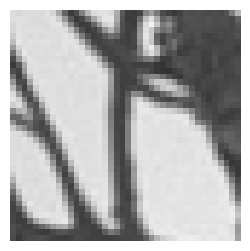

In [9]:
# choose a clean image (figure 4 in paper uses image_num=15)

image_num = 15
clean_im = single_image_loader(test_folder_path, image_num)

# Crop out a 40x40 patch (optional, helps for visibility.  Same values used for Figure 4 in paper).
clean_im = clean_im[100:140, 100:140]
dim1, dim2 = clean_im.shape


f , axs = plt.subplots(1,1 , figsize=(3,3))
axs.imshow(clean_im, 'gray', vmin=0, vmax = 1)
axs.axis('off');


## Interpretation: Nonlinear adaptive filtering

Since the BF-CNN can be interpreted as applying an adaptive linear transform, each pixel in the denoised image is a weighted sum of input pixels. The weighting function is one row of the Jacobian, evaluated at the input image. Here, we examine this weighting function for selected output pixels, as shown in Figure 4 of the paper.

### Interactive visualization of adaptive filters

Note that all weighting functions sum to approximately one, and thus compute a local average. Their shapes vary substantially, and are adapted to the underlying image content. As the noise level increases, the spatial extent of the weight functions increases in order to average out the noise, while respecting boundaries between different regions in the image, which results in dramatically different functions for each pixel (i.e., non-convolutional).

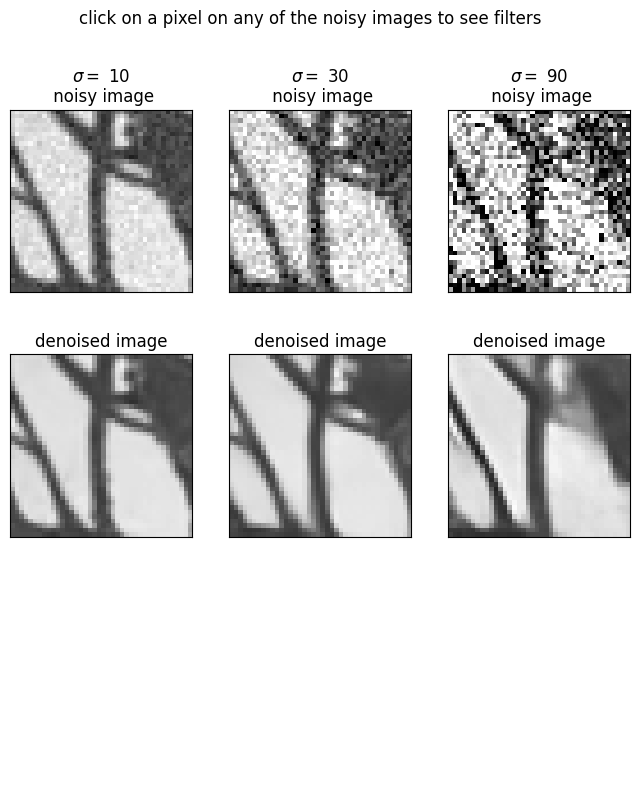

In [10]:
# Choose some noise levels to examine, relative to image intensities in range (0,255)
# Note: Figure 4 of paper uses [10, 30, 100].
noise_levels = [10, 30, 90]

global residual_imgs, input_imgs
input_imgs = []
residual_imgs = []

# %matplotlib notebook

fig = plt.figure(figsize = (8,9))
fig.suptitle('click on a pixel on any of the noisy images to see filters')
plt.axis('off')
ax_names=[]

for j in range(len(noise_levels)):
    # add noise
    noisy_im, _ = add_noise2(clean_im.reshape(1,dim1,dim2), noise_levels[j], 'S')
    # plot noisy
    ax = fig.add_subplot(3,len(noise_levels),j+1)
    ax.imshow(noisy_im[0], 'gray', vmin = 0, vmax = 1)
    ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    ax.set_title(r'$\sigma = $ ' + str(noise_levels[j]) + '\n noisy image')
    ax_names.append(ax)

    # denoise
    inp_test = torch.tensor(noisy_im.astype('float32'),requires_grad=True).unsqueeze(1)
    input_imgs.append(inp_test)
    residual= BF_CNN(inp_test)
    residual_imgs.append(residual)
    denoised = residual.squeeze(0).squeeze(0).data.numpy()

    # plot denoised
    ax = fig.add_subplot(3,len(noise_levels),j+len(noise_levels)+1)
    ax.imshow(denoised, 'gray', vmin = 0, vmax = 1)
    ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    ax.set_title( 'denoised image')

global last_pa
last_pa = []

ix, iy = 0, 0
def onclick(event):
    print("Click event captured")  # Debugging line

    global ix, iy
    ix, iy = int(event.xdata), int(event.ydata)

    # remove previous pixel marker
    if len(last_pa) != 0:
        for i in range(len(last_pa)):
            last_pa[i].set_visible(False)

    for j in range(len(noise_levels)):
        ax = fig.add_subplot(fig.add_subplot(3,len(noise_levels),j+len(noise_levels)*2+1))
        filt = torch.autograd.grad(residual_imgs[j][0,0,iy,ix], input_imgs[j], retain_graph=True)[0][0,0].data.numpy()
        limit =  max(np.abs(np.min( filt)), np.abs(np.max( filt)))
        ax.imshow(filt, 'RdGy', vmin= -limit, vmax = limit)
        ax.set_title('adaptive filter \n sum = \n' + str( np.round(np.sum(filt),2)))
        ax.tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
        pa = patches.Rectangle((ix-.5,iy-.5), width=1, height=1,edgecolor = [1,0,0], angle=0.0, facecolor='red', lw=1)
        ax_names[j].add_patch(pa)
        last_pa.append(pa)

cid = fig.canvas.mpl_connect('button_press_event', onclick);


In [11]:
def plot_filters_for_points(points, clean_im, dim1, dim2, patch_h=1, path_w=1, angle=5):
    """
    Plot noisy, denoised images, zoomed-in crops, and adaptive filters for two specified pixels, for each noise level.

    Args:
    points (list of tuples): List containing two tuples, each with the (x, y) coordinates of a pixel.
    clean_im (array): The clean image.
    dim1 (int): Dimension 1 of the image.
    dim2 (int): Dimension 2 of the image.
    """
    # Noise levels to examine
    noise_levels = [10, 30]
    width = 10  # Width for zooming and rectangle
    linewidth = 2  # Line width for rectangle

    for noise_level in noise_levels:
        # Add noise
        noisy_im, _ = add_noise2(clean_im.reshape(1, dim1, dim2), noise_level, 'S')

        # Denoise
        inp_test = torch.tensor(noisy_im.astype('float32'), requires_grad=True).unsqueeze(1)
        residual = BF_CNN(inp_test)
        denoised = residual.squeeze(0).squeeze(0).data.numpy()

        # Create figure for this noise level
        fig, axes = plt.subplots(nrows=len(points), ncols=4, figsize=(16, 9))
#         fig.suptitle(f'Noise Level {noise_level}')

        for i, point in enumerate(points):
            ix, iy = point

            # Noisy Image
            axes[i][0].imshow(noisy_im[0], 'gray', vmin=0, vmax=1)
            pa1 = patches.Rectangle((ix,iy), width=path_w, height=patch_h, angle=angle, edgecolor = [1,0,0], facecolor='red', lw=5)
            axes[i][0].add_patch(pa1)
            rect1 = patches.Rectangle((ix-width, iy-width), width*2, width*2, linewidth=linewidth, edgecolor='r', facecolor='none')
            axes[i][0].add_patch(rect1)
#             axes[i][0].set_title(f'Noisy Image\nPoint ({ix}, {iy})')
            axes[i][0].axis('off')

            # Denoised Image
            axes[i][1].imshow(denoised, 'gray', vmin=0, vmax=1)
            pa1 = patches.Rectangle((ix,iy), width=path_w, height=patch_h, angle=angle, edgecolor = [1,0,0], facecolor='red', lw=5)
            axes[i][1].add_patch(pa1)
            rect2 = patches.Rectangle((ix-width, iy-width), width*2, width*2, linewidth=linewidth, edgecolor='r', facecolor='none')
            axes[i][1].add_patch(rect2)
#             axes[i][1].set_title('Denoised Image')
            axes[i][1].axis('off')

            # Zoomed Crop
            zoomed_crop = denoised[iy-width:iy+width, ix-width:ix+width]

            axes[i][2].imshow(zoomed_crop, 'gray', vmin=0, vmax=1)
            pa1 = patches.Rectangle((width,width), width=path_w, height=patch_h, angle=angle, edgecolor = [1,0,0], facecolor='red', lw=5)
            axes[i][2].add_patch(pa1)
            rect1 = patches.Rectangle((0,0), width*2, width*2, linewidth= linewidth*3, edgecolor='r',facecolor='none')
#             axes[i][2].set_title('Zoomed Crop')
            axes[i][2].axis('off')

            # Gradient
            filt = torch.autograd.grad(residual[0, 0, iy, ix], inp_test, retain_graph=True)[0][0, 0].data.numpy()[iy-width:iy+width, ix-width:ix+width]
            limit = max(np.abs(np.min(filt)), np.abs(np.max(filt)))
            x = axes[i][3].imshow(filt, 'RdGy', vmin=-limit, vmax=limit)
#             axes[i][3].set_title(f'Gradient at ({ix}, {iy})')
            axes[i][3].axis('off')
            x.set_clim(-0.1, 0.1)
            plt.colorbar(x, ax=axes[i][3])

        plt.tight_layout()
        plt.show()

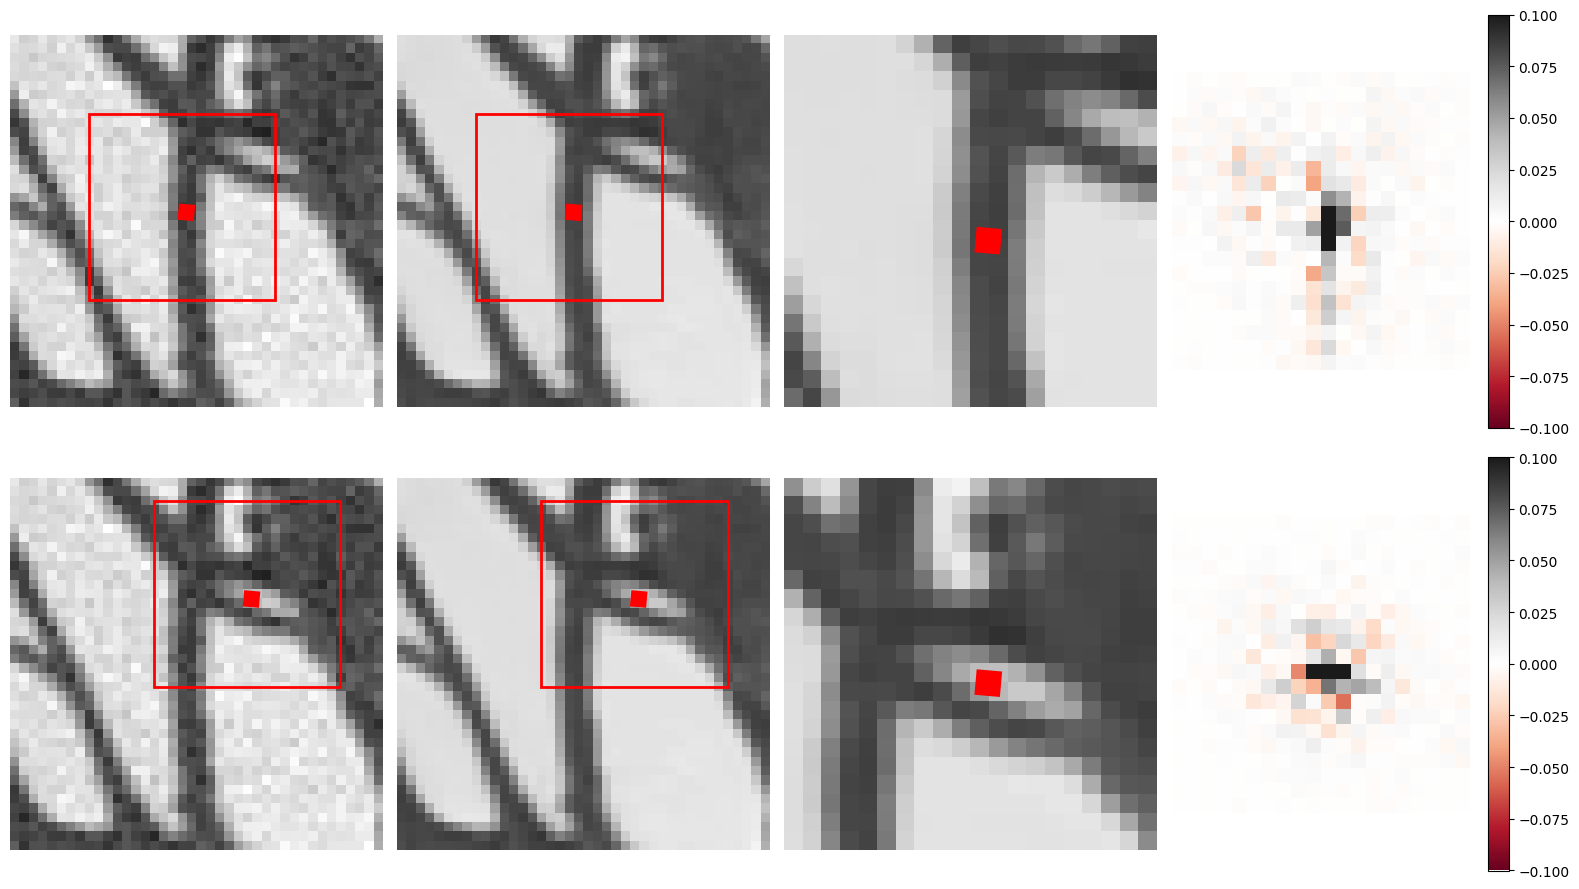

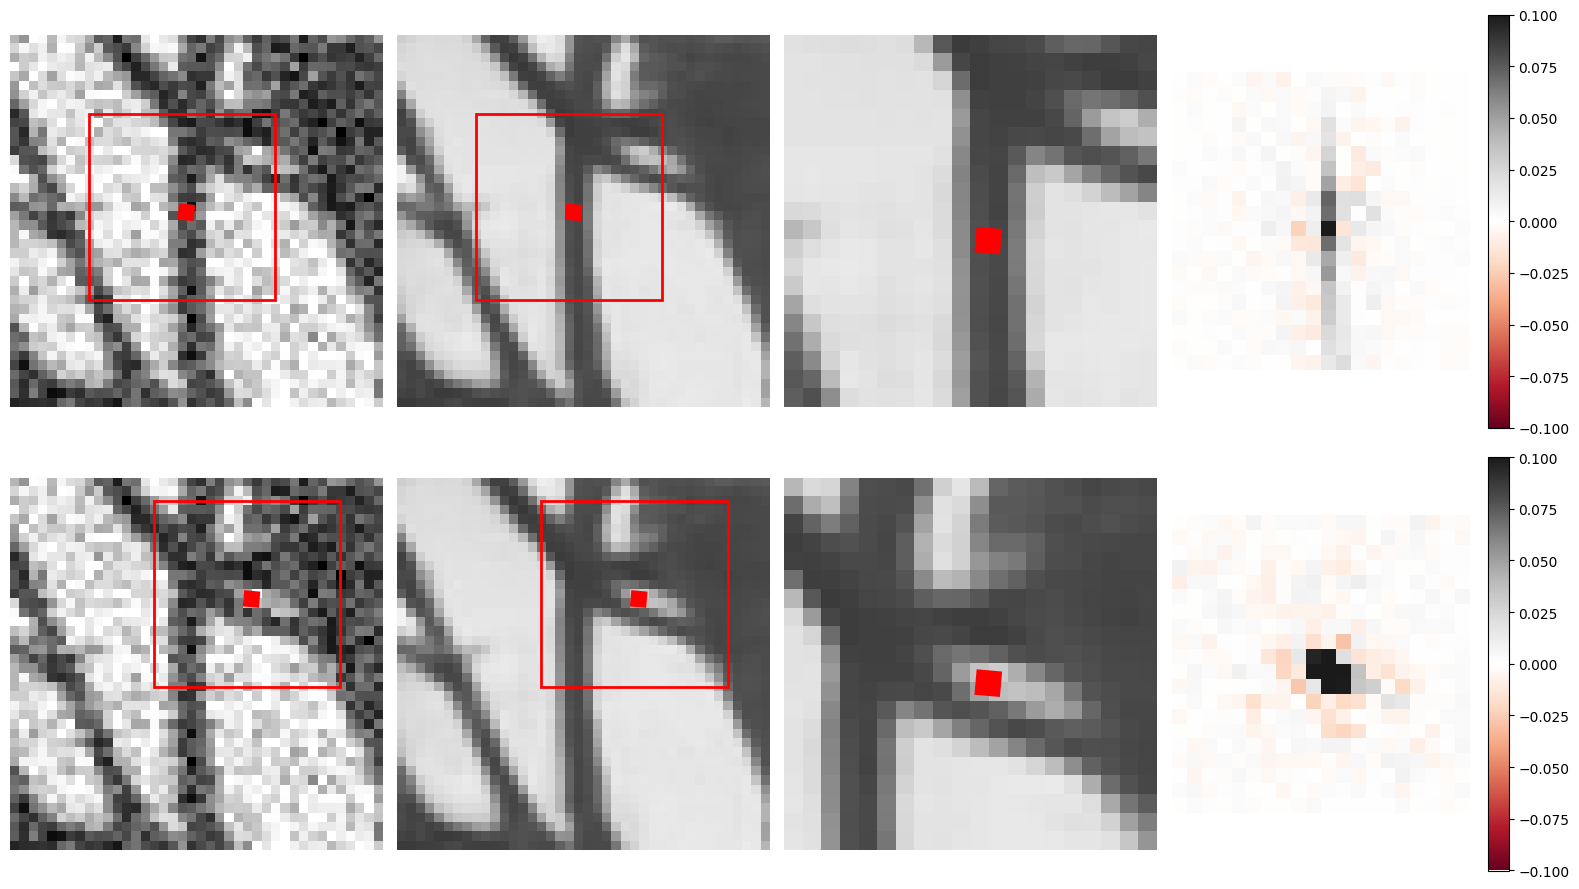

In [12]:
plot_filters_for_points([(18, 18), (25, 12)], clean_im, dim1, dim2)

In [13]:
# exit the interactive mofig.savefig('comparison_plot_piecewise_natural_image.pdf', bbox_inches='tight', dpi=300)de
f.canvas.mpl_disconnect(cid)


In [14]:
fig.savefig('comparison_plot_natural_image_gradient.pdf', bbox_inches='tight', dpi=300)

## Interpretation: Projection onto an adaptive signal subspace

We can study the effect of the linear transformation, A, by looking into its column space. A singular value decomposition of A, reveals that 1) most singular values are  close to zero, implying that the network is discarding all but a very low-dimensional portion of the input image, and 2) left and right singular vectors of the signal subspace are nearly identical. This means that we can interpret the action of the network as projecting the noisy signal onto a low-dimensional subspace.


### Compute SVD of Jacobian (adaptive linear transform) of denoiser


In [15]:
# Compute the Jacobian, evaluated at a noisy version of the clean image selected above.
# WARNING: slow computation! For a 40x40 patch, it can take between 1 and 2 minutes.

noisy_im = add_noise2(clean_im.reshape(1,dim1,dim2), 90, 'S')[0][0]

start_time_total = time.time()
A = calc_jacobian(noisy_im,BF_CNN)
print("---- Jacobian computation time --- %s seconds ---" % (time.time() - start_time_total))


---- Jacobian computation time --- 76.1785717010498 seconds ---


In [16]:
# Compute SVD of Jacobian
U , S, V = np.linalg.svd( A)


### Plot singular values

Note that most singular values are close to zero, suggesting
the denoiser is eliminating many dimensions.


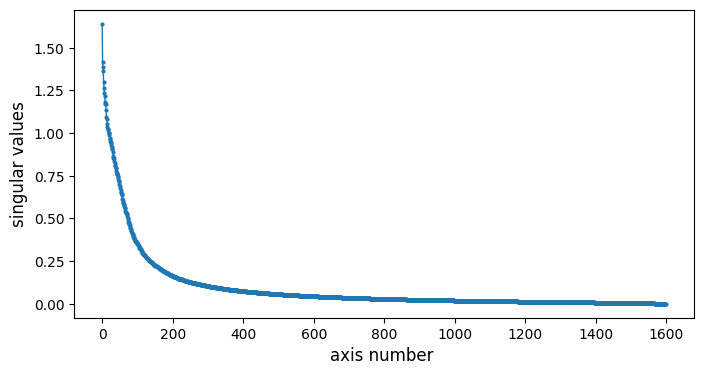

In [17]:
# Plot the singular values against the axis number.
f, ax = plt.subplots(1,1,figsize = (8,4))

ax.set_xlabel('axis number ', fontsize = 12, fontname= 'Times New Roman')
ax.set_ylabel('singular values', fontsize = 12, fontname= 'Times New Roman')

for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(10)
    tick.label1.set_fontname("Times New Roman")

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(10)
    tick.label1.set_fontname("Times New Roman")


ax.plot(S, '-o', alpha = 1, markersize = 2,linewidth=1);


### Visualize some example singular vectors with large singular values

These are 'features' of the input image that are preserved by the denoiser.

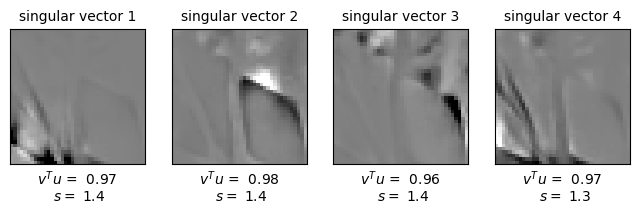

In [18]:
# Show some example singular vectors with large singular values
sing_vect_n = [1,2,3,4] # indices of the singular vectors for visualization

N = dim1*dim2 # dimensionality of the space

limit =  max(np.abs(np.min( U[:,sing_vect_n])), np.abs(np.max(U[:,sing_vect_n])))
f , axs = plt.subplots(1,len(sing_vect_n) , figsize=(8,3))
plt.subplots_adjust()
for i in range(len(sing_vect_n)):
    u = U[:,sing_vect_n[i]]
    v = V[sing_vect_n[i],:]
    axs[i].imshow(u.reshape(dim1,dim2), 'gray', vmin=-limit/2, vmax = limit/2)
    axs[i].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    axs[i].set_xlabel(r'$v^Tu$ =  '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(S[sing_vect_n[i]],1)),
                      fontsize = 10, fontname= 'Times New Roman');

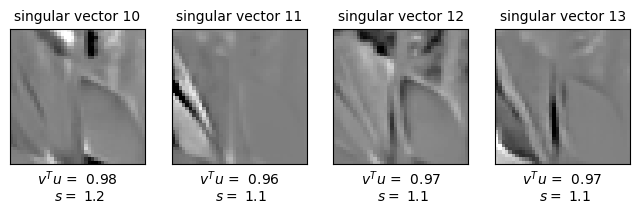

In [19]:
# Show some example singular vectors with large singular values
sing_vect_n = [10,11,12,13] # indices of the singular vectors for visualization

N = dim1*dim2 # dimensionality of the space

limit =  max(np.abs(np.min( U[:,sing_vect_n])), np.abs(np.max(U[:,sing_vect_n])))
f , axs = plt.subplots(1,len(sing_vect_n) , figsize=(8,3))
plt.subplots_adjust()
for i in range(len(sing_vect_n)):
    u = U[:,sing_vect_n[i]]
    v = V[sing_vect_n[i],:]
    axs[i].imshow(u.reshape(dim1,dim2), 'gray', vmin=-limit/2, vmax = limit/2)
    axs[i].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    axs[i].set_xlabel(r'$v^Tu$ =  '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(S[sing_vect_n[i]],1)),
                      fontsize = 10, fontname= 'Times New Roman');

### Visualize some example singular vectors with small singular values

These are 'features' of the input image that are discarded by the denoiser.

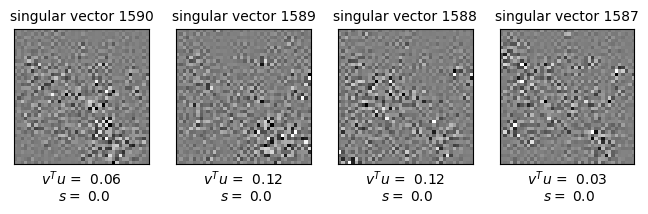

In [20]:
# Show some example singular vectors with small singular values
sing_vect_n = [N-10,N-11,N-12,N-13] # indices of the singular vectors for visualization

limit =  max(np.abs(np.min( U[:,sing_vect_n])), np.abs(np.max(U[:,sing_vect_n])))
f , axs = plt.subplots(1,len(sing_vect_n) , figsize=(8,3))
plt.subplots_adjust()
for i in range(len(sing_vect_n)):
    u = U[:,sing_vect_n[i]]
    v = V[sing_vect_n[i],:]
    axs[i].imshow(u.reshape(dim1,dim2), 'gray', vmin=-limit/2, vmax = limit/2)
    axs[i].set_title('singular vector '+str(sing_vect_n[i]), fontsize = 10, fontname= 'Times New Roman')
    axs[i].tick_params(bottom=False,left=False,labelleft=False,labelbottom=False)
    axs[i].set_xlabel(r'$v^Tu$ =  '+str(np.round( np.dot(u,v) ,2))+ '\n $s =$ '+str(np.round(S[sing_vect_n[i]],1)),
                      fontsize = 10, fontname= 'Times New Roman');

### Left and right singular vectors with significant singular values are nearly identical


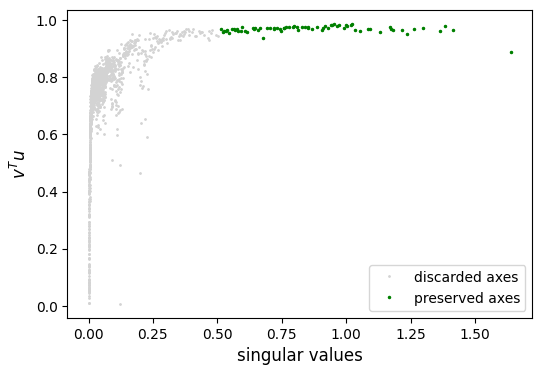

In [21]:
# Compute dot products of left and right singular vectors (u.v=1).
subspace_dim = int(np.sum((S)**2))
uvdots = []
for j in range(N):
    v = V[j,:]
    u = U[:,j]
    uvdots.append(abs(np.dot(v,u)))

# Plot dot products as a function of associated singular value
f, ax = plt.subplots(1,1,figsize = (6,4))
ax.plot(S, uvdots, '.', color = 'lightgray', markersize=2 , label='discarded axes')
ax.plot(S[0:subspace_dim], uvdots[0:subspace_dim], '.',markersize=3,color='green',alpha=1, label = 'preserved axes')
ax.set_ylabel(r'${v}^T{u} $', fontsize = 12, fontname= 'Times New Roman')
ax.set_xlabel('singular values', fontsize = 12, fontname= 'Times New Roman')
plt.legend()
for tick in ax.xaxis.get_major_ticks():
    tick.label1.set_fontsize(10)
    tick.label1.set_fontname("Times New Roman")

for tick in ax.yaxis.get_major_ticks():
    tick.label1.set_fontsize(10)
    tick.label1.set_fontname("Times New Roman")
